[View in Colaboratory](https://colab.research.google.com/github/bt22dr/deep-learning-papers/blob/master/code/gan_fashion_mnist.ipynb)

# GAN Fashion MNIST
*   Tensorflow Eager 공식 튜토리얼의 [gan example 코드](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/gan/mnist.py)를 참고하여 fashion mnist 데이터를 생성하는 GAN 코드를 작성함.
*   아래 [4]번 셀의 url로 Tensorboard에 접속하여 학습 과정(생성 이미지, loss) 변화를 확인할 수 있다.

In [0]:
%matplotlib inline

import os
import sys
import time

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfd = tf.contrib.distributions
layers = tf.keras.layers

tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Found GPU at: /device:GPU:0
TensorFlow version: 1.9.0-rc2
Eager execution: True


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2018-07-04 02:13:19--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.175.98.137, 54.209.18.85, 52.72.251.164, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.175.98.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.41MB/s    in 0.7s    

2018-07-04 02:13:20 (7.41 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://45a92bbc.ngrok.io


In [0]:
!rm -rf checkpoints/ log/

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


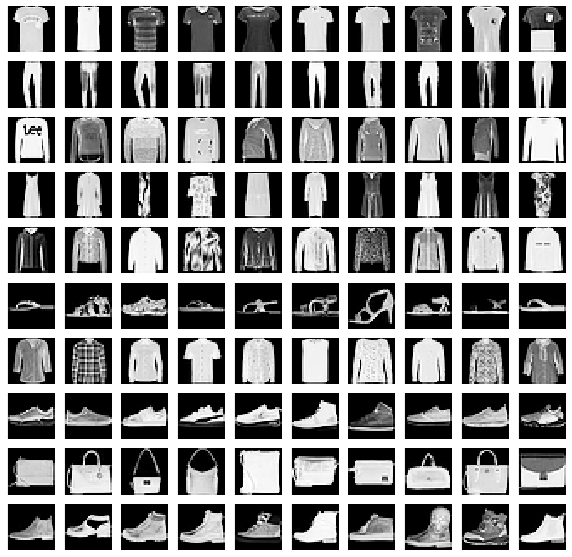

In [0]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

for i, ax_row in enumerate(axes):
  imgs = x_test[np.where(y_test == i)[0][:10]]
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(imgs[j], cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [0]:
class Discriminator(tf.keras.Model):
  """GAN Discriminator.
  A network to differentiate between generated and real handwritten digits.
  """

  def __init__(self, data_format):
    """Creates a model for discriminating between real and generated digits.
    Args:
      data_format: Either 'channels_first' or 'channels_last'.
        'channels_first' is typically faster on GPUs while 'channels_last' is
        typically faster on CPUs. See
        https://www.tensorflow.org/performance/performance_guide#data_formats
    """
    super(Discriminator, self).__init__(name='')
    if data_format == 'channels_first':
      self._input_shape = [-1, 1, 28, 28]
    else:
      assert data_format == 'channels_last'
      self._input_shape = [-1, 28, 28, 1]
    self.conv1 = layers.Conv2D(
        64, 5, padding='SAME', data_format=data_format, activation=None)
    self.bn1 = layers.BatchNormalization(momentum=0.8)
    self.ac1 = layers.LeakyReLU(alpha=0.2)
    self.pool1 = layers.AveragePooling2D(2, 2, data_format=data_format)
    self.conv2 = layers.Conv2D(
        128, 5, data_format=data_format, activation=None)
    self.bn2 = layers.BatchNormalization(momentum=0.8)
    self.ac2 = layers.LeakyReLU(alpha=0.2)
    self.pool2 = layers.AveragePooling2D(2, 2, data_format=data_format)
    self.flatten = layers.Flatten()
    self.fc1 = layers.Dense(1024, activation=tf.nn.leaky_relu)
    self.fc2 = layers.Dense(1, activation=None)

  def call(self, inputs):
    """Return two logits per image estimating input authenticity.
    Users should invoke __call__ to run the network, which delegates to this
    method (and not call this method directly).
    Args:
      inputs: A batch of images as a Tensor with shape [batch_size, 28, 28, 1]
        or [batch_size, 1, 28, 28]
    Returns:
      A Tensor with shape [batch_size] containing logits estimating
      the probability that corresponding digit is real.
    """
    
    x = tf.reshape(inputs, self._input_shape)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [0]:
class Generator(tf.keras.Model):
  """Generator of handwritten digits similar to the ones in the MNIST dataset.
  """

  def __init__(self, data_format):
    """Creates a model for discriminating between real and generated digits.
    Args:
      data_format: Either 'channels_first' or 'channels_last'.
        'channels_first' is typically faster on GPUs while 'channels_last' is
        typically faster on CPUs. See
        https://www.tensorflow.org/performance/performance_guide#data_formats
    """
    super(Generator, self).__init__(name='')
    self.data_format = data_format
    # We are using 128 6x6 channels as input to the first deconvolution layer
    if data_format == 'channels_first':
      self._pre_conv_shape = [-1, 512, 3, 3]
    else:
      assert data_format == 'channels_last'
      self._pre_conv_shape = [-1, 3, 3, 512]
    self.fc1 = layers.Dense(3 * 3 * 512, activation=tf.nn.leaky_relu)

    # In call(), we reshape the output of fc1 to _pre_conv_shape

    # Deconvolution layer. Resulting image shape: (batch, 7, 7, 512)
    self.conv1 = layers.Conv2DTranspose(
        512, 3, strides=2, activation=None, data_format=data_format)
    self.bn1 = layers.BatchNormalization()
    self.ac1 = layers.LeakyReLU(alpha=0.2)

    # Deconvolution layer. Resulting image shape: (batch, 14, 14, 128)
    self.conv2 = layers.Conv2DTranspose(
        128, 2, strides=2, activation=None, data_format=data_format)
    self.bn2 = layers.BatchNormalization()
    self.ac2 = layers.LeakyReLU(alpha=0.2)
    
    # Deconvolution layer. Resulting image shape: (batch, 28, 28, 1)
    self.conv3 = layers.Conv2DTranspose(
        1, 2, strides=2, activation=tf.nn.sigmoid, data_format=data_format)

  def call(self, inputs):
    """Return a batch of generated images.
    Users should invoke __call__ to run the network, which delegates to this
    method (and not call this method directly).
    Args:
      inputs: A batch of noise vectors as a Tensor with shape
        [batch_size, length of noise vectors].
    Returns:
      A Tensor containing generated images. If data_format is 'channels_last',
      the shape of returned images is [batch_size, 28, 28, 1], else
      [batch_size, 1, 28, 28]
    """

    x = self.fc1(inputs)
    x = tf.reshape(x, shape=self._pre_conv_shape)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac2(x)
    x = self.conv3(x)
    return x

In [0]:
# dummy_noise = tf.random_uniform(shape=[1,100], minval=-1., maxval=1.)
# dummy_g = Generator('channels_first')
# dummy_d = Discriminator('channels_first')
# dummy_d(dummy_g(dummy_noise))

# print(dummy_g.summary())
# print(dummy_d.summary())

In [0]:
def discriminator_loss(discriminator_real_outputs, discriminator_gen_outputs):
  """Original discriminator loss for GANs, with label smoothing.
  See `Generative Adversarial Nets` (https://arxiv.org/abs/1406.2661) for more
  details.
  Args:
    discriminator_real_outputs: Discriminator output on real data.
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
  Returns:
    A scalar loss Tensor.
  """

  loss_on_real = tf.losses.sigmoid_cross_entropy(
      tf.ones_like(discriminator_real_outputs),
      discriminator_real_outputs,
      label_smoothing=0.1)
  loss_on_generated = tf.losses.sigmoid_cross_entropy(
      tf.zeros_like(discriminator_gen_outputs), discriminator_gen_outputs)
  loss = loss_on_real + loss_on_generated
  tf.contrib.summary.scalar('discriminator_loss', loss)
  return loss


def generator_loss(discriminator_gen_outputs):
  """Original generator loss for GANs.
  L = -log(sigmoid(D(G(z))))
  See `Generative Adversarial Nets` (https://arxiv.org/abs/1406.2661)
  for more details.
  Args:
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
  Returns:
    A scalar loss Tensor.
  """
  loss = tf.losses.sigmoid_cross_entropy(
      tf.ones_like(discriminator_gen_outputs), discriminator_gen_outputs)
  tf.contrib.summary.scalar('generator_loss', loss)
  return loss

In [0]:
def train_one_epoch(generator, discriminator, generator_optimizer,
                    discriminator_optimizer, dataset, step_counter,
                    log_interval, noise_dim):
  """Trains `generator` and `discriminator` models on `dataset`.
  Args:
    generator: Generator model.
    discriminator: Discriminator model.
    generator_optimizer: Optimizer to use for generator.
    discriminator_optimizer: Optimizer to use for discriminator.
    dataset: Dataset of images to train on.
    step_counter: An integer variable, used to write summaries regularly.
    log_interval: How many steps to wait between logging and collecting
      summaries.
    noise_dim: Dimension of noise vector to use.
  """

  total_generator_loss = 0.0
  total_discriminator_loss = 0.0
  for (batch_index, images) in enumerate(tfe.Iterator(dataset)):
    with tf.device('/cpu:0'):
      tf.assign_add(step_counter, 1)

    with tf.contrib.summary.record_summaries_every_n_global_steps(
        log_interval, global_step=step_counter):
      current_batch_size = images.shape[0]
      noise = tf.random_uniform(
          shape=[current_batch_size, noise_dim],
          minval=-1.,
          maxval=1.,
          seed=batch_index)

      with tf.GradientTape(persistent=True) as g:
        generated_images = generator(noise)
        tf.contrib.summary.image(
            'generated_images',
            tf.reshape(generated_images, [-1, 28, 28, 1]),
            max_images=10)

        discriminator_gen_outputs = discriminator(generated_images)
        discriminator_real_outputs = discriminator(images)
        discriminator_loss_val = discriminator_loss(discriminator_real_outputs,
                                                    discriminator_gen_outputs)
        total_discriminator_loss += discriminator_loss_val

        generator_loss_val = generator_loss(discriminator_gen_outputs)
        total_generator_loss += generator_loss_val

      generator_grad = g.gradient(generator_loss_val, generator.variables)
      discriminator_grad = g.gradient(discriminator_loss_val,
                                      discriminator.variables)

      generator_optimizer.apply_gradients(
          zip(generator_grad, generator.variables))
      discriminator_optimizer.apply_gradients(
          zip(discriminator_grad, discriminator.variables))

      if log_interval and batch_index > 0 and batch_index % log_interval == 0:
        print('Batch #%d\tAverage Generator Loss: %.6f\t'
              'Average Discriminator Loss: %.6f' %
              (batch_index, total_generator_loss / batch_index,
               total_discriminator_loss / batch_index))

In [0]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument(
    '--data-dir',
    type=str,
    default='/tmp/tensorflow/mnist/input_data',
    help=('Directory for storing input data (default '
          '/tmp/tensorflow/mnist/input_data)'))
parser.add_argument(
    '--batch-size',
    type=int,
    default=128,
    metavar='N',
    help='input batch size for training (default: 128)')
parser.add_argument(
    '--log-interval',
    type=int,
    default=100,
    metavar='N',
    help=('number of batches between logging and writing summaries '
          '(default: 100)'))
parser.add_argument(
    '--output_dir',
    type=str,
    default='log',
    metavar='DIR',
    help='Directory to write TensorBoard summaries (defaults to none)')
parser.add_argument(
    '--checkpoint_dir',
    type=str,
    default='./checkpoints/',
    metavar='DIR',
    help=('Directory to save checkpoints in (once per epoch) (default '
          '/tmp/tensorflow/mnist/checkpoints/)'))
parser.add_argument(
    '--lr',
    type=float,
    default=0.001,
    metavar='LR',
    help='learning rate (default: 0.001)')
parser.add_argument(
    '--noise',
    type=int,
    default=100,
    metavar='N',
    help='Length of noise vector for generator input (default: 100)')
parser.add_argument(
    '--no-gpu',
    action='store_true',
    default=False,
    help='disables GPU usage even if a GPU is available')

FLAGS, unparsed = parser.parse_known_args()

In [0]:
(device, data_format) = ('/gpu:0', 'channels_first')
if FLAGS.no_gpu or tfe.num_gpus() <= 0:
  (device, data_format) = ('/cpu:0', 'channels_last')
print('Using device %s, and data format %s.' % (device, data_format))

# Load the datasets
dataset = (
    tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000) # TODO: keras ImageDataGenerator 사용
    .batch(FLAGS.batch_size))

# Create the models and optimizers.
model_objects = {
    'generator': Generator(data_format),
    'discriminator': Discriminator(data_format),
    'generator_optimizer': tf.train.AdamOptimizer(FLAGS.lr),
    'discriminator_optimizer': tf.train.AdamOptimizer(FLAGS.lr),
    'step_counter': tf.train.get_or_create_global_step(),
}

# Prepare summary writer and checkpoint info
summary_writer = tf.contrib.summary.create_summary_file_writer(
    FLAGS.output_dir, flush_millis=1000)
checkpoint_prefix = os.path.join(FLAGS.checkpoint_dir, 'ckpt')
latest_cpkt = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
if latest_cpkt:
  print('Using latest checkpoint at ' + latest_cpkt)
checkpoint = tfe.Checkpoint(**model_objects)
# Restore variables on creation if a checkpoint exists.
checkpoint.restore(latest_cpkt)

with tf.device(device):
  for _ in range(50):
    start = time.time()
    with summary_writer.as_default():
      train_one_epoch(dataset=dataset, log_interval=FLAGS.log_interval,
                      noise_dim=FLAGS.noise, **model_objects)
    end = time.time()
    checkpoint.save(checkpoint_prefix)
    print('\nTrain time for epoch #%d (step %d): %f' %
          (checkpoint.save_counter.numpy(),
           checkpoint.step_counter.numpy(),
           end - start))

Using device /gpu:0, and data format channels_first.
Batch #100	Average Generator Loss: 4.613593	Average Discriminator Loss: 0.404839
Batch #200	Average Generator Loss: 4.799693	Average Discriminator Loss: 0.397065
Batch #300	Average Generator Loss: 4.501735	Average Discriminator Loss: 0.428407
Batch #400	Average Generator Loss: 4.140295	Average Discriminator Loss: 0.460551

Train time for epoch #1 (step 469): 83.062642
Batch #100	Average Generator Loss: 2.975557	Average Discriminator Loss: 0.610849
Batch #200	Average Generator Loss: 2.841428	Average Discriminator Loss: 0.621334
Batch #300	Average Generator Loss: 2.819219	Average Discriminator Loss: 0.609577
Batch #400	Average Generator Loss: 2.807676	Average Discriminator Loss: 0.603831

Train time for epoch #2 (step 938): 81.481785
Batch #100	Average Generator Loss: 2.788160	Average Discriminator Loss: 0.616446
Batch #200	Average Generator Loss: 2.747702	Average Discriminator Loss: 0.610185
Batch #300	Average Generator Loss: 2.716531


Train time for epoch #10 (step 4690): 81.425045
Batch #100	Average Generator Loss: 2.401350	Average Discriminator Loss: 0.677028
Batch #200	Average Generator Loss: 2.377123	Average Discriminator Loss: 0.687724
Batch #300	Average Generator Loss: 2.367474	Average Discriminator Loss: 0.688353
Batch #400	Average Generator Loss: 2.366095	Average Discriminator Loss: 0.684652

Train time for epoch #11 (step 5159): 81.307917
Batch #100	Average Generator Loss: 2.441148	Average Discriminator Loss: 0.681310
Batch #200	Average Generator Loss: 2.448670	Average Discriminator Loss: 0.672708
Batch #300	Average Generator Loss: 2.470311	Average Discriminator Loss: 0.666703
Batch #400	Average Generator Loss: 2.476490	Average Discriminator Loss: 0.666276

Train time for epoch #12 (step 5628): 81.123002
Batch #100	Average Generator Loss: 2.507216	Average Discriminator Loss: 0.654890
Batch #200	Average Generator Loss: 2.401089	Average Discriminator Loss: 0.676996
Batch #300	Average Generator Loss: 2.365372

Batch #100	Average Generator Loss: 2.336296	Average Discriminator Loss: 0.720965
Batch #200	Average Generator Loss: 2.254841	Average Discriminator Loss: 0.718307
Batch #300	Average Generator Loss: 2.276478	Average Discriminator Loss: 0.709646
Batch #400	Average Generator Loss: 2.280713	Average Discriminator Loss: 0.705532

Train time for epoch #21 (step 9849): 81.362090
Batch #100	Average Generator Loss: 2.380249	Average Discriminator Loss: 0.685466
Batch #200	Average Generator Loss: 2.325768	Average Discriminator Loss: 0.697282
Batch #300	Average Generator Loss: 2.305171	Average Discriminator Loss: 0.698484
Batch #400	Average Generator Loss: 2.329154	Average Discriminator Loss: 0.698668

Train time for epoch #22 (step 10318): 81.369447
Batch #100	Average Generator Loss: 2.238387	Average Discriminator Loss: 0.722111
Batch #200	Average Generator Loss: 2.278658	Average Discriminator Loss: 0.719995
Batch #300	Average Generator Loss: 2.333825	Average Discriminator Loss: 0.698444
Batch #400

Batch #200	Average Generator Loss: 2.267985	Average Discriminator Loss: 0.707269
Batch #300	Average Generator Loss: 2.266539	Average Discriminator Loss: 0.704821
Batch #400	Average Generator Loss: 2.262756	Average Discriminator Loss: 0.709836

Train time for epoch #31 (step 14539): 81.309180
Batch #100	Average Generator Loss: 2.186942	Average Discriminator Loss: 0.744683
Batch #200	Average Generator Loss: 2.207270	Average Discriminator Loss: 0.728601
Batch #300	Average Generator Loss: 2.211640	Average Discriminator Loss: 0.721046
Batch #400	Average Generator Loss: 2.213317	Average Discriminator Loss: 0.718315

Train time for epoch #32 (step 15008): 81.311426
Batch #100	Average Generator Loss: 2.292696	Average Discriminator Loss: 0.702558
Batch #200	Average Generator Loss: 2.297823	Average Discriminator Loss: 0.702388
Batch #300	Average Generator Loss: 2.276202	Average Discriminator Loss: 0.706523
Batch #400	Average Generator Loss: 2.263338	Average Discriminator Loss: 0.707128

Train ti

Batch #300	Average Generator Loss: 2.316772	Average Discriminator Loss: 0.688883
Batch #400	Average Generator Loss: 2.313278	Average Discriminator Loss: 0.693255

Train time for epoch #41 (step 19229): 81.551605
Batch #100	Average Generator Loss: 2.388876	Average Discriminator Loss: 0.686252
Batch #200	Average Generator Loss: 2.304561	Average Discriminator Loss: 0.707520
Batch #300	Average Generator Loss: 2.292768	Average Discriminator Loss: 0.697706
Batch #400	Average Generator Loss: 2.273520	Average Discriminator Loss: 0.701849

Train time for epoch #42 (step 19698): 81.372463
Batch #100	Average Generator Loss: 2.286720	Average Discriminator Loss: 0.740944
Batch #200	Average Generator Loss: 2.314745	Average Discriminator Loss: 0.709370
Batch #300	Average Generator Loss: 2.295374	Average Discriminator Loss: 0.711144
Batch #400	Average Generator Loss: 2.297902	Average Discriminator Loss: 0.707723

Train time for epoch #43 (step 20167): 81.294686
Batch #100	Average Generator Loss: 2.341

Batch #400	Average Generator Loss: 2.360766	Average Discriminator Loss: 0.681207

Train time for epoch #51 (step 23919): 81.419735
Batch #100	Average Generator Loss: 2.358708	Average Discriminator Loss: 0.680095
Batch #200	Average Generator Loss: 2.298880	Average Discriminator Loss: 0.684143
Batch #300	Average Generator Loss: 2.297853	Average Discriminator Loss: 0.687382
Batch #400	Average Generator Loss: 2.296592	Average Discriminator Loss: 0.687486

Train time for epoch #52 (step 24388): 81.419714
Batch #100	Average Generator Loss: 2.377096	Average Discriminator Loss: 0.682364
Batch #200	Average Generator Loss: 2.363606	Average Discriminator Loss: 0.668513
Batch #300	Average Generator Loss: 2.340436	Average Discriminator Loss: 0.675329
Batch #400	Average Generator Loss: 2.359665	Average Discriminator Loss: 0.674357

Train time for epoch #53 (step 24857): 81.477056
Batch #100	Average Generator Loss: 2.312150	Average Discriminator Loss: 0.682167
Batch #200	Average Generator Loss: 2.292


Train time for epoch #61 (step 28609): 81.249840
Batch #100	Average Generator Loss: 2.404189	Average Discriminator Loss: 0.668026
Batch #200	Average Generator Loss: 2.408638	Average Discriminator Loss: 0.655076
Batch #300	Average Generator Loss: 2.411171	Average Discriminator Loss: 0.657220
Batch #400	Average Generator Loss: 2.427215	Average Discriminator Loss: 0.654733

Train time for epoch #62 (step 29078): 81.314191
Batch #100	Average Generator Loss: 2.449875	Average Discriminator Loss: 0.650764
Batch #200	Average Generator Loss: 2.460275	Average Discriminator Loss: 0.650094
Batch #300	Average Generator Loss: 2.455421	Average Discriminator Loss: 0.645609
Batch #400	Average Generator Loss: 2.454320	Average Discriminator Loss: 0.649728

Train time for epoch #63 (step 29547): 81.305981
Batch #100	Average Generator Loss: 2.474370	Average Discriminator Loss: 0.648779
Batch #200	Average Generator Loss: 2.491377	Average Discriminator Loss: 0.644959
Batch #300	Average Generator Loss: 2.499

Batch #100	Average Generator Loss: 2.655646	Average Discriminator Loss: 0.629253
Batch #200	Average Generator Loss: 2.643497	Average Discriminator Loss: 0.614088
Batch #300	Average Generator Loss: 2.632405	Average Discriminator Loss: 0.617822
Batch #400	Average Generator Loss: 2.612200	Average Discriminator Loss: 0.618745

Train time for epoch #72 (step 33768): 81.348130
Batch #100	Average Generator Loss: 2.570486	Average Discriminator Loss: 0.634801
Batch #200	Average Generator Loss: 2.551255	Average Discriminator Loss: 0.632105
Batch #300	Average Generator Loss: 2.558984	Average Discriminator Loss: 0.624494
Batch #400	Average Generator Loss: 2.563034	Average Discriminator Loss: 0.625510

Train time for epoch #73 (step 34237): 81.370147
Batch #100	Average Generator Loss: 2.675214	Average Discriminator Loss: 0.608644
Batch #200	Average Generator Loss: 2.640026	Average Discriminator Loss: 0.613599
Batch #300	Average Generator Loss: 2.624137	Average Discriminator Loss: 0.613656
Batch #40

Batch #200	Average Generator Loss: 2.790135	Average Discriminator Loss: 0.580602
Batch #300	Average Generator Loss: 2.791845	Average Discriminator Loss: 0.579779
Batch #400	Average Generator Loss: 2.782073	Average Discriminator Loss: 0.580708

Train time for epoch #82 (step 38458): 81.313025
Batch #100	Average Generator Loss: 2.853315	Average Discriminator Loss: 0.573523
Batch #200	Average Generator Loss: 2.819653	Average Discriminator Loss: 0.589623
Batch #300	Average Generator Loss: 2.807005	Average Discriminator Loss: 0.586059
Batch #400	Average Generator Loss: 2.786300	Average Discriminator Loss: 0.589178

Train time for epoch #83 (step 38927): 81.349859
Batch #100	Average Generator Loss: 2.829833	Average Discriminator Loss: 0.589772
Batch #200	Average Generator Loss: 2.813693	Average Discriminator Loss: 0.579215
Batch #300	Average Generator Loss: 2.799077	Average Discriminator Loss: 0.580792
Batch #400	Average Generator Loss: 2.811620	Average Discriminator Loss: 0.579190

Train ti

Batch #300	Average Generator Loss: 3.027343	Average Discriminator Loss: 0.544634
Batch #400	Average Generator Loss: 3.013950	Average Discriminator Loss: 0.546860

Train time for epoch #92 (step 43148): 81.286852
Batch #100	Average Generator Loss: 2.984671	Average Discriminator Loss: 0.553116
Batch #200	Average Generator Loss: 2.962470	Average Discriminator Loss: 0.549717
Batch #300	Average Generator Loss: 2.976453	Average Discriminator Loss: 0.547181
Batch #400	Average Generator Loss: 2.970902	Average Discriminator Loss: 0.549194

Train time for epoch #93 (step 43617): 81.256873
Batch #100	Average Generator Loss: 3.072097	Average Discriminator Loss: 0.549529
Batch #200	Average Generator Loss: 3.042412	Average Discriminator Loss: 0.541874
Batch #300	Average Generator Loss: 3.031399	Average Discriminator Loss: 0.540816
Batch #400	Average Generator Loss: 3.022814	Average Discriminator Loss: 0.541563

Train time for epoch #94 (step 44086): 81.385758
Batch #100	Average Generator Loss: 3.031

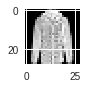

In [0]:
noise = np.random.random((1, FLAGS.noise))*2-1
generated_images = model_objects["generator"](noise)
generated_image = np.squeeze(generated_images.numpy())
plt.figure(figsize=(1,1))
plt.imshow(generated_image, cmap='gray')

# Generated Images

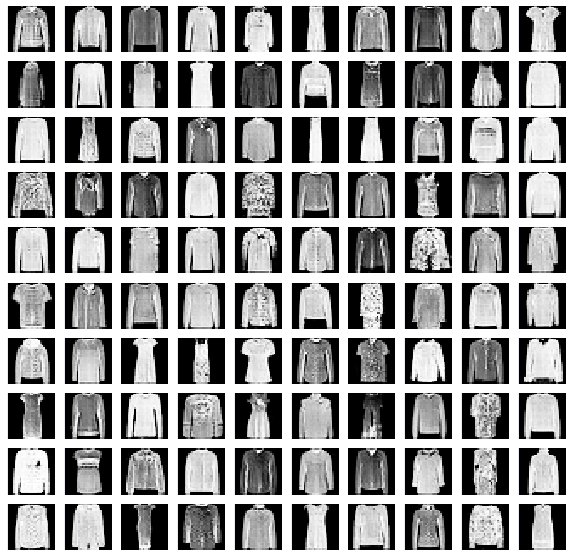

In [0]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

noise = np.random.random((100, FLAGS.noise))*2-1
generated_images = model_objects["generator"](noise)
generated_images = np.squeeze(generated_images.numpy())

for i, ax_row in enumerate(axes):
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(generated_images[i*10+j], cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)